In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss
from sklearn.calibration import CalibratedClassifierCV
import nltk
from sklearn.ensemble import RandomForestClassifier
import warnings
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import hstack
from sklearn.ensemble import StackingClassifier
warnings.filterwarnings("ignore")
import time
from sklearn.preprocessing import normalize
import re
from xgboost import XGBRFRegressor
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [110]:
df=pd.read_csv('/content/drive/MyDrive/CancerPrediction/training_variants')
df1=pd.read_csv('/content/drive/MyDrive/CancerPrediction/training_text',sep='\|\|',engine='python')

In [111]:

print('No. of rows: ',df.shape[0])
print('No. of features: ',df.shape[1])
print('Features',df.columns.values)

No. of rows:  3321
No. of features:  4
Features ['ID' 'Gene' 'Variation' 'Class']


In [112]:
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [113]:
df1.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [114]:
nltk.download('stopwords')
stop_words=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
def nlp_preprocessing(total_text,index,column):
    if type(total_text ) is not int:
        total_text=re.sub('[^a-zA-z0-9\n]',' ',total_text)
        total_text=re.sub('\s+',' ',total_text)
        total_text=total_text.lower()
        for i in stop_words:
            if i in total_text:
                total_text=total_text.replace(i,' ')
        total_text=re.sub('\s+',' ',total_text)
        df1[column][index]=total_text

        

In [116]:
start_time=time.time()
print(start_time)
for index, row in df1.iterrows():
    if type(row['Text']) is str:
        nlp_preprocessing(row['Text'], index, 'Text')
    else:
        print("there is no text description for id:",index)
print('Time for preprocessing text: ',time.time()-start_time," seconds")

1659981521.3775277
there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time for preprocessing text:  65.5548255443573  seconds


In [117]:
result=pd.merge(df,df1,on='ID',how='left')
result.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,c cl epen en k e c k gul e v r e f fun n l ce ...
1,1,CBL,W802*,2,b r c b ckgr un n n ce lung cer n clc er gene...
2,2,CBL,Q249E,2,b r c b ckgr un n n ce lung cer n clc er gene...
3,3,CBL,N454D,3,cen ev ence e n r e h cqu un p n l n l ch n w...
4,4,CBL,L399V,4,nc gen c u n n r c c b l e ge l ph cbl gene h...


In [118]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [119]:
result.loc[result['Text'].isnull(),'Text']=result['Gene']+' '+result['Variation']

In [120]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,FANCA S1088F


In [121]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')
x_train,test_df,y_train,y_test=train_test_split(result,y_true,stratify=y_true,test_size=0.2)
train_df,cv_df,y_train,Y_cv=train_test_split(x_train,y_train,stratify=y_train,test_size=0.2)


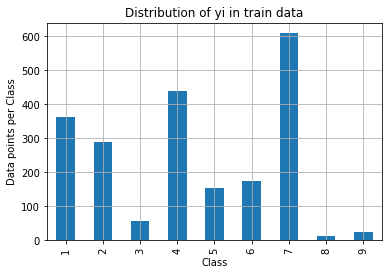

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


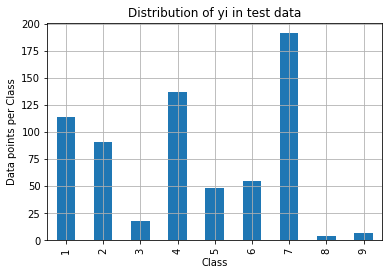

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


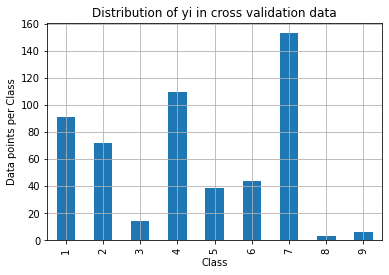

In [122]:
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


 # Predicting Using a Random Model

 #### valid values for cmap 
 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [123]:
def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
   
    A=(((C.T)/(C.sum(axis=1))).T)
    B=(C/C.sum(axis=0))
    labels=[1,2,3,4,5,6,7,8,9]
    cm='gist_yarg_r'
    print('\t\t\t'*2,' Confusion Matrix ')
    print()
    plt.figure(figsize=(20,7))
    sns.heatmap(C,annot=True,cmap=cm,fmt='.4f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print('\t\t\t'*2,' Precision Matrix ','\t\t')
    print()
    plt.figure(figsize=(20,7))
    sns.heatmap(B,annot=True,cmap=cm,fmt='.4f',xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print('\t\t\t'*2,' Recall Matrix ','\t\t')
    plt.figure(figsize=(20,7))
    sns.heatmap(A,cmap=cm,xticklabels=labels,yticklabels=labels,fmt='.4f',annot=True)
    plt.xlabel('Predicted Class')
    
    plt.ylabel('Original Class')
    plt.show()

In [124]:
test_data_len=test_df.shape[0]
cv_data_len=cv_df.shape[0]
 
    
cv_predicted_y=np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs=np.random.rand(1,9)
    cv_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
print("Log  loss on Cross Validation Data using Random Model",log_loss(Y_cv,cv_predicted_y,eps=1e-15))

Log  loss on Cross Validation Data using Random Model 2.4629056863969914


						  Confusion Matrix 



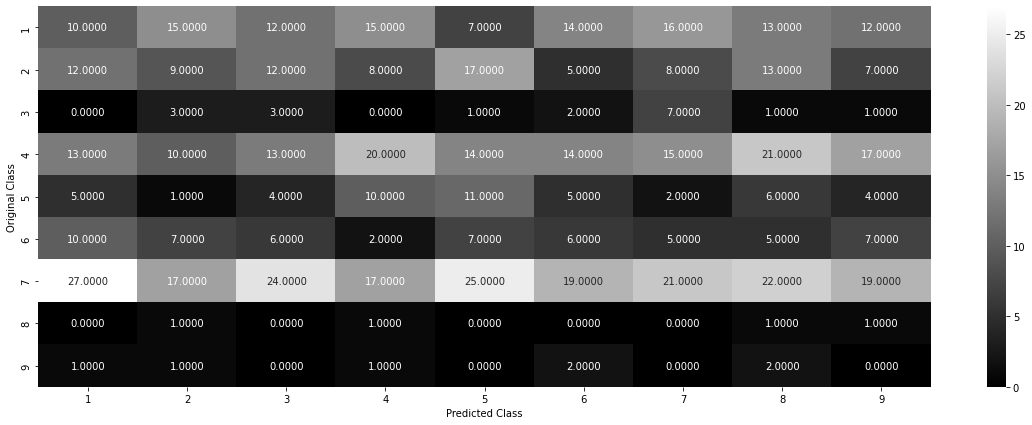

						  Precision Matrix  		



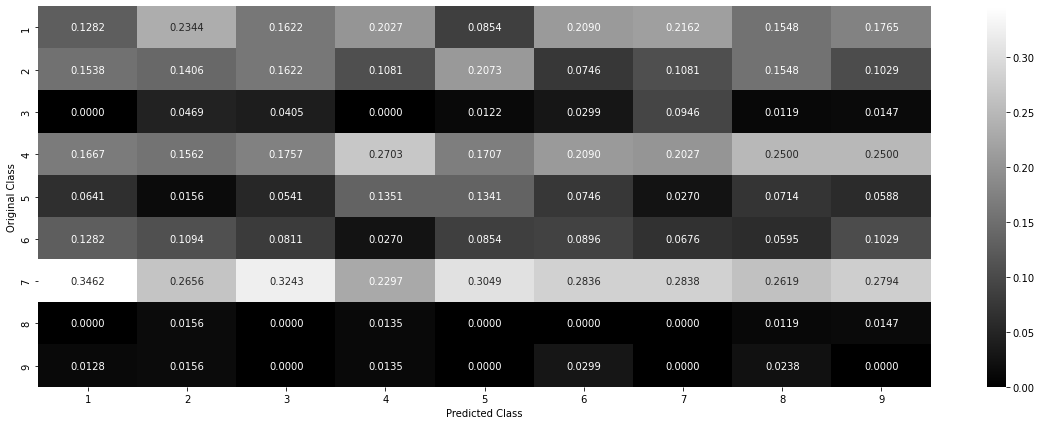

						  Recall Matrix  		


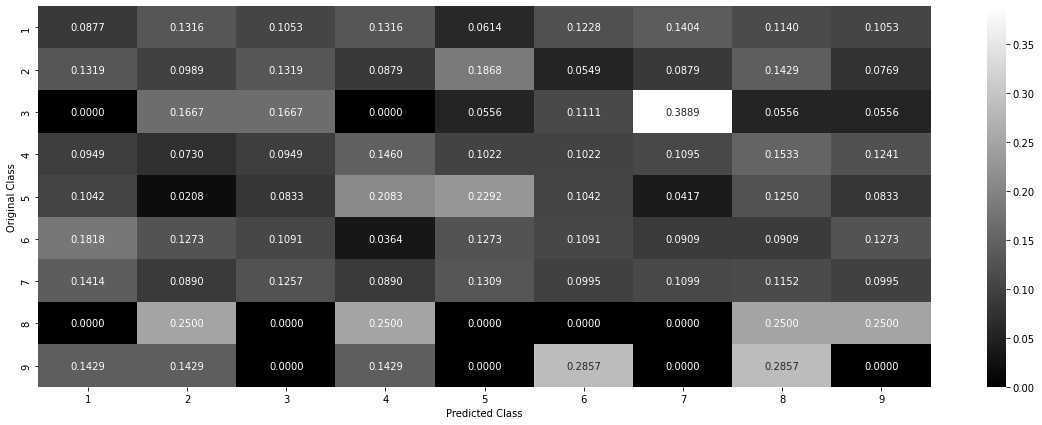

In [125]:
test_predicted_y=np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs=np.random.rand(1,9)
    test_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])



predicted_y=np.argmax(test_predicted_y,axis=1)
plot_confusion_matrix(y_test,predicted_y+1)

## Univariate Analysis


In [126]:
def fea_dict(alpha,feature):
    value_count=train_df.value_counts()
    gv=dict()
    for i,denominator in value_count.items():
        vec=[]
        for k in range(1,10):
            cls_cnt=train_df.loc[(train_df['Class']==k) &(train_df[feature]==i)]
            vec.append((cls_cnt.shape[0]+alpha*10)/(denominator+90*alpha))
        gv[i]=vec
    return gv

def get_cv_feature(alpha,feature,df):
    gv_dict=fea_dict(alpha,feature)
    value_count=train_df[feature].value_counts()
    gv_fea=[]
    for index,row in df.iterrows():
       
        if row[feature] in dict(gv_dict).keys():
               gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea



### Univariate Analysis on Gene Feature

#### How many categories are there and how are they distributed?

In [127]:
unique_genes=train_df['Gene'].value_counts()
print('No. of unique Genes: ',unique_genes.shape[0])


No. of unique Genes:  234


[0.076742   0.05131827 0.04378531 0.04048964 0.04001883 0.03201507
 0.0287194  0.02212806 0.0193032  0.01836158]


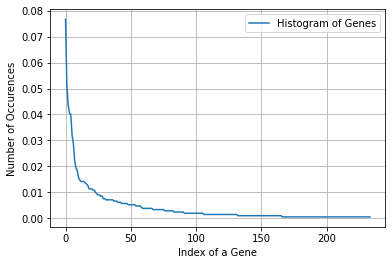

In [128]:
s=sum(unique_genes.values)
print(unique_genes.values[:10]/s)
h=unique_genes.values/s
plt.plot(h,label='Histogram of Genes')
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurences')
plt.legend()
plt.grid()
plt.show()

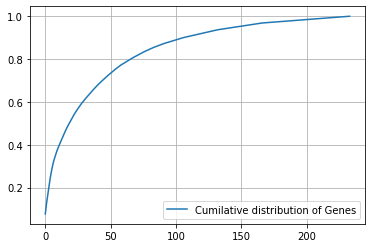

In [129]:
c=np.cumsum(h)


plt.plot(c,label='Cumilative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

### How to featurize this Gene feature ?
 We can featurize gene using 
  1. One hot Encoding
  2. Response coding
  

#### Response Coding

In [130]:
alpha=1
train_gene_feature_responseCoding=np.array(get_cv_feature(alpha,'Gene',train_df))
test_gene_feature_responseCoding=np.array(get_cv_feature(alpha,'Gene',test_df))
cv_gene_feature_responseCoding=np.array(get_cv_feature(alpha,'Gene',cv_df))

In [131]:
train_df['Gene'].head()

967       ESR1
3108    DNMT3B
497       TP53
3120      KRAS
2721      BRAF
Name: Gene, dtype: object

### One hot Encoding

In [132]:
gene_vectorizer=CountVectorizer()
train_gene_feature_onehotCoding=gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding=gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding=gene_vectorizer.transform(cv_df['Gene'])



In [133]:
print('No. of Features for responsecoding',train_gene_feature_responseCoding.shape[1])
print('No. of Features for One Hot Encoding',train_gene_feature_onehotCoding.shape[1])


No. of Features for responsecoding 9
No. of Features for One Hot Encoding 234


In [134]:
gene_vectorizer.get_feature_names()


['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid2',
 'arid5b',
 'asxl1',
 'atm',
 'aurka',
 'aurkb',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'dusp4',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'i

### How good is this gene feature in predicting y_i ?

In [135]:
alpha=[10**x for x in range(-5,1)]

cv_log_error_array=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log')
    clf.fit(train_gene_feature_onehotCoding,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding,y_train)
    predict_y=sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(Y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print('For values of alpha =',i,' The log loss is: ',log_loss(Y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    

For values of alpha = 1e-05  The log loss is:  1.20927353031948
For values of alpha = 0.0001  The log loss is:  1.1893258537846596
For values of alpha = 0.001  The log loss is:  1.2283037029433834
For values of alpha = 0.01  The log loss is:  1.345540257584065
For values of alpha = 0.1  The log loss is:  1.4265371857659819
For values of alpha = 1  The log loss is:  1.4640371194856836


#### Is this  Gene feature stable across all data sets (Train test CV)? 

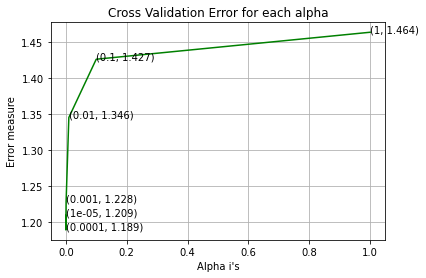

For values of best alpha =  0.0001 The train log loss is: 0.9835923766680962
For values of best alpha =  0.0001 The cross validation log loss is: 1.1897291154384522
For values of best alpha =  0.0001 The test log loss is: 1.212176369126744


In [136]:
best_alpha=np.argmin(cv_log_error_array)
clf=SGDClassifier(alpha=alpha[best_alpha],penalty='l2',loss='log')
clf.fit(train_gene_feature_onehotCoding,y_train)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding,y_train)
predict_y=sig_clf.predict_proba(train_gene_feature_onehotCoding)
print()
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


####  Conclusion : There is not huge difference between log loss on train,test and cv data so we can assume its a stable feature

## Univariate Analysis on Variation feature

#### What type of feature it is?

Variation is a categorical variable

In [137]:
unique_variations=train_df['Variation'].value_counts()
print('Number of Unique Variations: ',unique_variations.shape[0])
unique_variations.head()

Number of Unique Variations:  1926


Deletion                54
Truncating_Mutations    53
Amplification           44
Fusions                 23
Overexpression           5
Name: Variation, dtype: int64

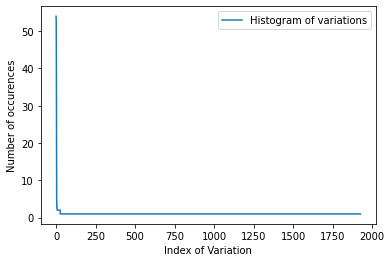

In [138]:
plt.plot(unique_variations.values,label='Histogram of variations')
plt.xlabel('Index of Variation')
plt.ylabel('Number of occurences')
plt.legend()
plt.show()

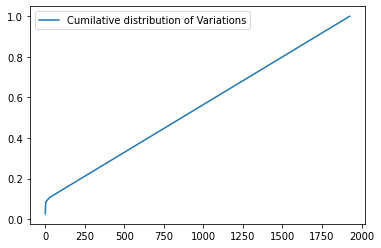

In [139]:
h=unique_variations.values/(sum(unique_variations.values))
c=np.cumsum(h)
plt.plot(c,label='Cumilative distribution of Variations')
plt.legend()
plt.show()

## How to featurize this Variation feature?
 There are two ways we can featurize this variable 
 1. One hot Encoding
 2. Response Coding

##### Response Coding

In [140]:
# FOR LAPLACE SMOOTHING
alpha=1
train_variation_feature_responseCoding=np.array(get_cv_feature(alpha,'Variation',train_df))
test_variation_feature_responseCoding=np.array(get_cv_feature(alpha,'Variation',test_df))
cv_variation_feature_responseCoding=np.array(get_cv_feature(alpha,'Variation',cv_df))
print('Train is a converted fearture using the response coding ',train_variation_feature_responseCoding.shape)


Train is a converted fearture using the response coding  (2124, 9)


#### One Hot Coding

In [141]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding=variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding=variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding=variation_vectorizer.transform(cv_df['Variation'])
print('train_variation_feature_onehotEncoded shape ',train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded shape  (2124, 1950)


### How good is this variation feature predicting y_i?

For values of alpha= 1e-05 the log loss is:  1.697163794730185
For values of alpha= 0.0001 the log loss is:  1.6901021653646722
For values of alpha= 0.001 the log loss is:  1.693090715947427
For values of alpha= 0.01 the log loss is:  1.699430749704759
For values of alpha= 0.1 the log loss is:  1.714364336004977
For values of alpha= 1 the log loss is:  1.7157006796807162


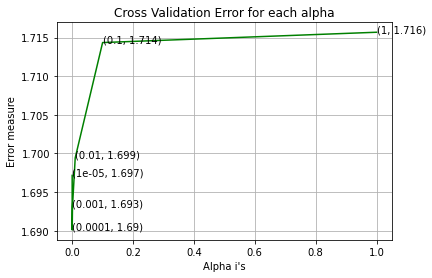

For values of best alpha =  0.0001 The train log loss is: 0.6703342354158558
For values of best alpha =  0.0001 The cross validation log loss is: 1.6901542837411514
For values of best alpha =  0.0001 The test log loss is: 1.707656452688792


In [142]:
alpha=[10**x for x in range(-5,1)]

cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log')
    clf.fit(train_variation_feature_onehotCoding,y_train)
    
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding,y_train)
    
    predict_y=sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error.append(log_loss(Y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    print('For values of alpha=',i,"the log loss is: ",cv_log_error[-1])
    
fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error,c='g')
for i,txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],np.round(txt,3)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel('Error measure')
plt.show()
best_alpha = np.argmin(cv_log_error)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


#### The variation in log loss on train , test and cv is high

In [143]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1926  genes in test and cross validation data sets?
Ans
1. In test data 70 out of 665 : 10.526315789473683
2. In cross validation data 47 out of  532 : 8.834586466165414


#### From above analysis we can conclude that Variation feature is not stable across train,cv and test

## Univariate Analysis on Text Feature


#### How many unique words are present in train data?

In [144]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['Text'].split():
            dictionary[word] +=1
    return dictionary

In [145]:
import math


def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['Text'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['Text'].split()))
            row_index += 1
    return text_feature_responseCoding

In [146]:
text_vectorizer = CountVectorizer(min_df=2)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['Text'])

train_text_features= text_vectorizer.get_feature_names()

train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 21291


In [147]:
dict_list=[]
for i in range(1,10):
    cls_text=train_df[train_df['Class']==i]
    dict_list.append(extract_dictionary_paddle(cls_text))
total_dict=extract_dictionary_paddle(cls_text)
confuse_array=[]
for i in train_text_features:
    ratios=[]
    max_val=-1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10)/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array=np.array(confuse_array)


In [148]:
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [149]:
print('The shape of response coded feature are',train_text_feature_responseCoding.shape)

The shape of response coded feature are (2124, 9)


In [150]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [151]:
train_text_feature_onehotCoding=normalize(train_text_feature_onehotCoding,axis=0)
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['Text'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['Text'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [152]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [153]:
print(Counter(sorted_text_occur))

Counter({2: 3640, 3: 1900, 4: 1668, 6: 986, 5: 881, 7: 796, 8: 716, 9: 502, 10: 487, 12: 418, 13: 334, 14: 330, 11: 303, 18: 249, 16: 246, 15: 222, 17: 190, 20: 188, 19: 187, 21: 178, 24: 177, 22: 166, 48: 158, 26: 144, 28: 139, 46: 138, 25: 122, 36: 114, 23: 112, 27: 99, 32: 97, 30: 92, 42: 89, 35: 87, 31: 82, 40: 81, 29: 79, 34: 76, 43: 71, 33: 69, 44: 67, 45: 62, 49: 61, 39: 61, 56: 59, 51: 59, 50: 59, 54: 56, 63: 53, 41: 49, 68: 48, 52: 48, 38: 46, 37: 45, 62: 42, 60: 41, 47: 41, 59: 40, 72: 39, 66: 38, 61: 38, 58: 38, 57: 38, 78: 36, 64: 36, 96: 35, 70: 34, 86: 33, 71: 32, 53: 32, 75: 31, 55: 31, 91: 28, 85: 28, 90: 27, 82: 26, 65: 26, 92: 25, 76: 25, 73: 25, 100: 24, 98: 24, 67: 24, 108: 23, 84: 23, 74: 23, 79: 22, 69: 22, 120: 21, 112: 21, 95: 21, 80: 21, 77: 21, 124: 19, 104: 19, 81: 19, 140: 18, 127: 18, 105: 18, 102: 18, 89: 18, 103: 17, 88: 17, 83: 17, 142: 16, 126: 16, 94: 16, 93: 16, 148: 15, 116: 15, 115: 15, 110: 15, 87: 15, 153: 14, 143: 14, 138: 14, 111: 14, 99: 14, 15

For alpha  1e-05  the log loss error is  1.2302938352392243
For alpha  0.0001  the log loss error is  1.187588014323375
For alpha  0.001  the log loss error is  1.1917826075271076
For alpha  0.01  the log loss error is  1.3525721555686736
For alpha  0.1  the log loss error is  1.5254250191621583
For alpha  1  the log loss error is  1.6326807186001187
For alpha  10  the log loss error is  1.6474643293934637


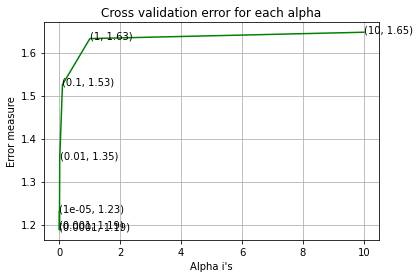

For values of best alpha =  0.0001 The train log loss is: 0.6397511387711474
For values of best alpha =  0.0001 The cross validation log loss is: 1.184421387466333
For values of best alpha =  0.0001 The test log loss is: 1.1777042822365464


In [154]:
alpha=[10**x for x in range(-5,2)]
cv_log_error=[]
for i in alpha:
    clf=SGDClassifier(alpha=i,penalty='l2',loss='log')
    clf.fit(train_text_feature_onehotCoding,y_train)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding,y_train)
    predict_y=sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error.append(log_loss(Y_cv,predict_y,labels=clf.classes_))
    print('For alpha ',i,' the log loss error is ',cv_log_error[-1])
fi,ax=plt.subplots()
ax.plot(alpha,cv_log_error,c='g')
for i,txt in enumerate(np.round(cv_log_error,2)):
    ax.annotate((alpha[i],np.round(txt,2)),(alpha[i],cv_log_error[i]))
plt.grid()
plt.title('Cross validation error for each alpha')
plt.xlabel("Alpha i's")
plt.ylabel('Error measure')
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))




### The variation in log loss is high 

In [155]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['Text'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [156]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

98.12 % of word of test data appeared in train data
98.264 % of word of Cross Validation appeared in train data


### the text data seems to be stable


# Machine Learning Models

In [157]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [158]:
def report_log_loss(train_x,train_y,test_x,test_y,clf):
    clf.fit(train_x,train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x,train_y)
    sig_clf_probs=sig_clf.predict_proba(test_x)
    return log_loss(test_y,sig_clf_probs,eps=1e-15)


In [159]:
# Merging ,gene ,variation and text features

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [160]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 23475)
(number of data points * number of features) in test data =  (665, 23475)
(number of data points * number of features) in cross validation data = (532, 23475)


In [161]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


In [162]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Base Line Model

### Naive Bayes

For alpha  1e-05  log loss is  : 1.2497952546500444
For alpha  0.0001  log loss is  : 1.2479432798938448
For alpha  0.001  log loss is  : 1.2443057031079554
For alpha  0.01  log loss is  : 1.2399797298246267
For alpha  0.1  log loss is  : 1.2287302889114837
For alpha  1  log loss is  : 1.2485889529060306
For alpha  10  log loss is  : 1.2965929898153563


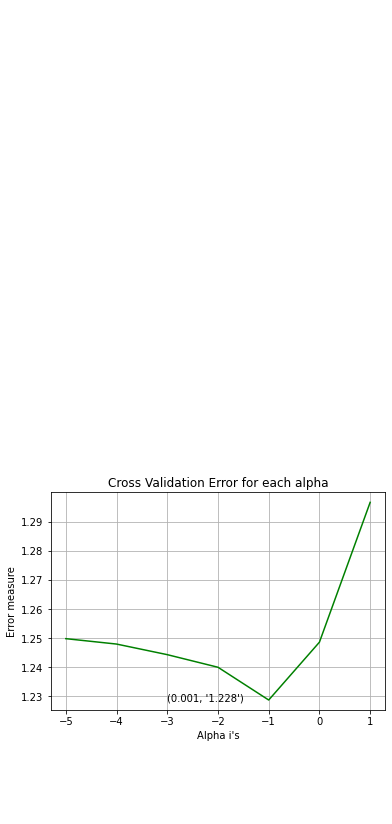

For values of best alpha =  0.1 The train log loss is: 0.7700584920801952
For values of best alpha =  0.1 The cross validation log loss is: 1.2287302889114837
For values of best alpha =  0.1 The test log loss is: 1.277838921931757


In [163]:
alpha=[10**x for x in range(-5,2)]
cv_log_error=[]
for i in alpha:
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding,train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
   
    print("For alpha ",i," log loss is  :",cv_log_error[-1])
          

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
best_alpha=np.argmin(cv_log_error)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



Log Loss : 1.2287302889114837
Number of missclassified point : 0.38345864661654133
						  Confusion Matrix 



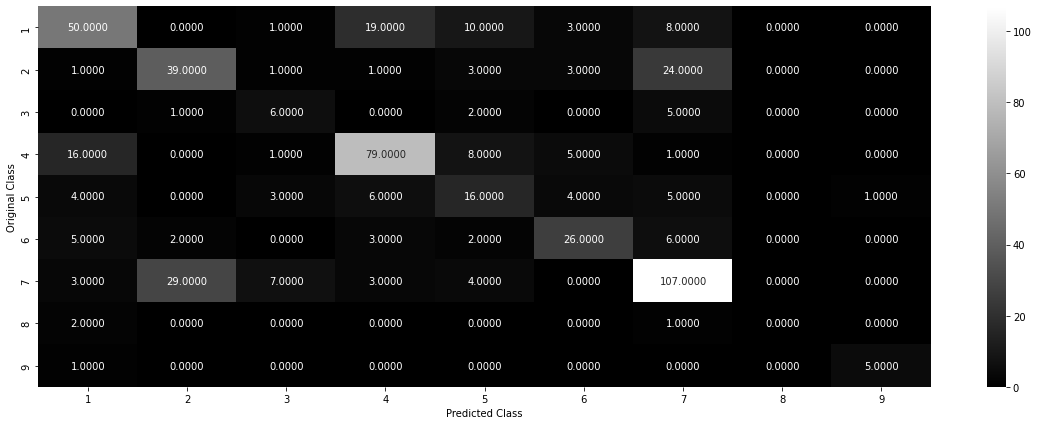

						  Precision Matrix  		



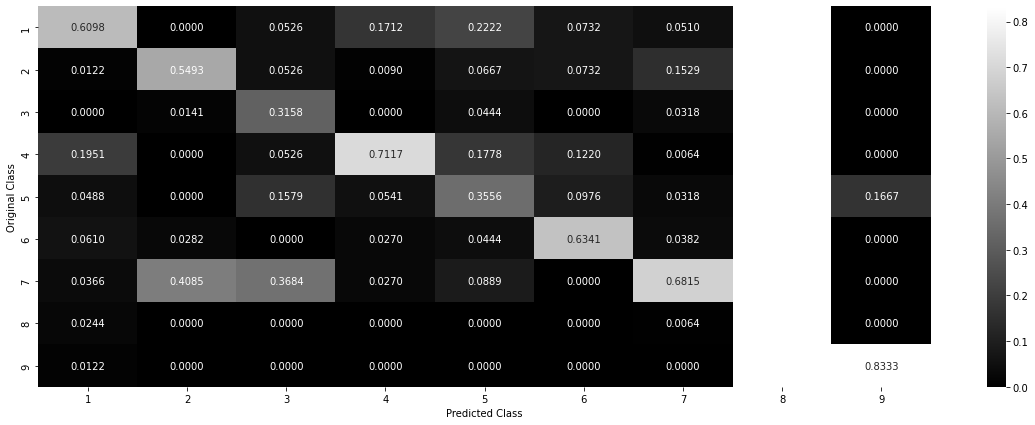

						  Recall Matrix  		


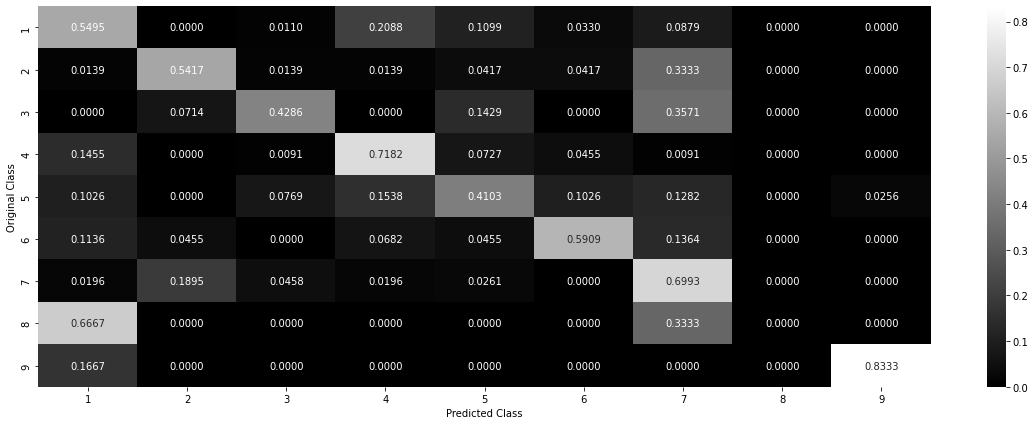

In [164]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
best_alpha_NB=alpha[best_alpha]
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [165]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['Text'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
           
            if (v-(fea1_len+fea2_len))>len( text_vec.get_feature_names()):
              continue
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))
        

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [166]:
test_point_index = 105
no_feature = 100

predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]

print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)



Predicted Class : 7
Predicted Class Probabilities: [[0.0806 0.0591 0.013  0.0891 0.0365 0.0319 0.6814 0.0049 0.0036]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [167]:
clf.coef_.shape


(9, 23475)

## K Nearest Neighbour Classification

For k=  10  neighbours log loss is  1.2026226069646155
For k=  20  neighbours log loss is  1.1931240408134933
For k=  30  neighbours log loss is  1.2000504790847817
For k=  40  neighbours log loss is  1.2043571034858715
For k=  50  neighbours log loss is  1.207416290242167
For k=  60  neighbours log loss is  1.2024327710431948
For k=  70  neighbours log loss is  1.2061698466852686
For k=  80  neighbours log loss is  1.2090195733799718
For k=  90  neighbours log loss is  1.2106117871414328


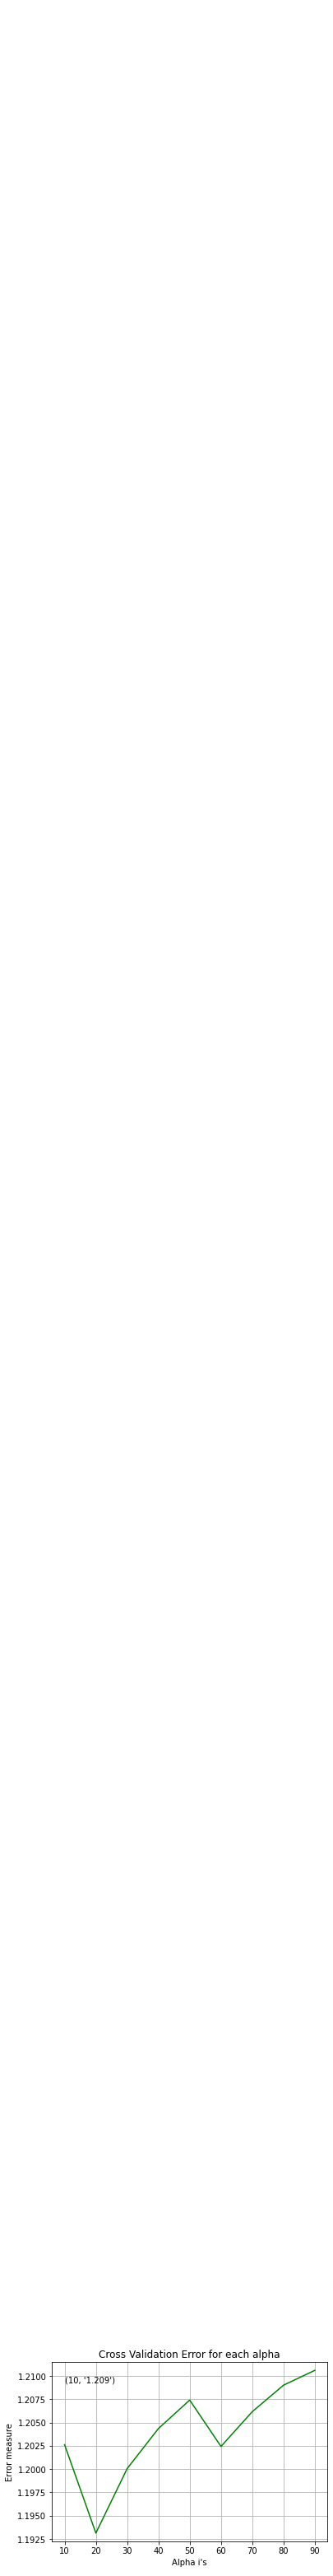

<Figure size 72x72 with 0 Axes>

For values of best alpha =  20 The train log loss is: 0.8750122139282803
For values of best alpha =  20 The cross validation log loss is: 1.1931240408134933
For values of best alpha =  20 The test log loss is: 1.2632861487255647


In [168]:
alpha=[10*x for x in range(1,10)]
cv_log_error=[]
for i in alpha:
  clf=KNeighborsClassifier(n_neighbors=i)
  clf.fit(train_x_responseCoding,train_y)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_responseCoding,train_y)
  sog_clf_probs=sig_clf.predict_proba(cv_x_responseCoding)
  cv_log_error.append(log_loss(cv_y,sog_clf_probs,eps=1e-15))
  print('For k= ',i,' neighbours log loss is ',cv_log_error[-1])


fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.figure(figsize=(1,1))
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1931240408134933
Number of mis-classified points : 0.40037593984962405
						  Confusion Matrix 



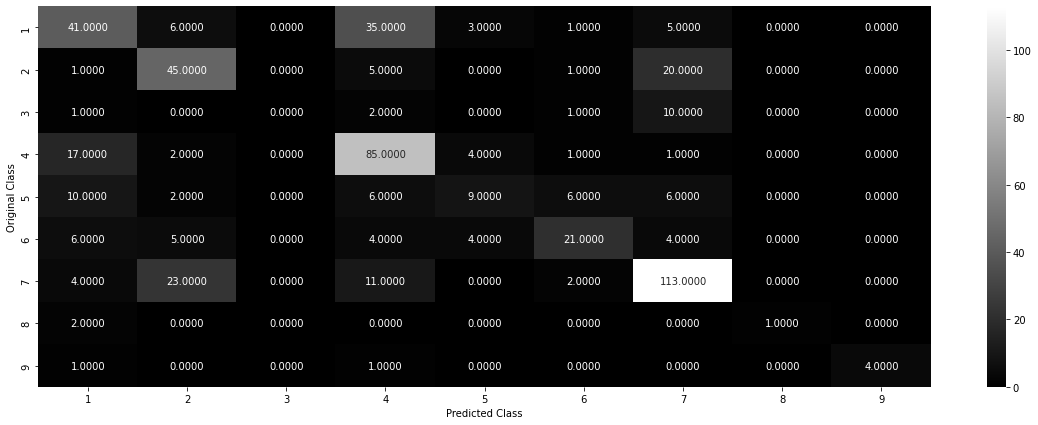

						  Precision Matrix  		



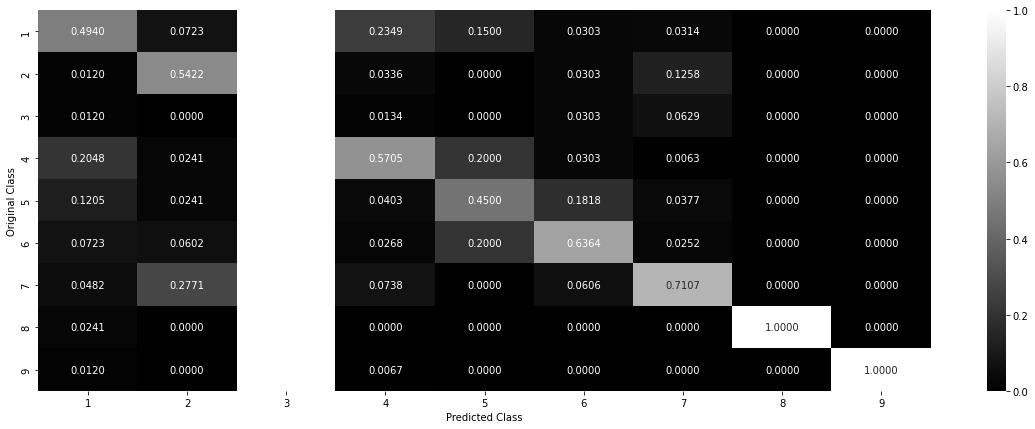

						  Recall Matrix  		


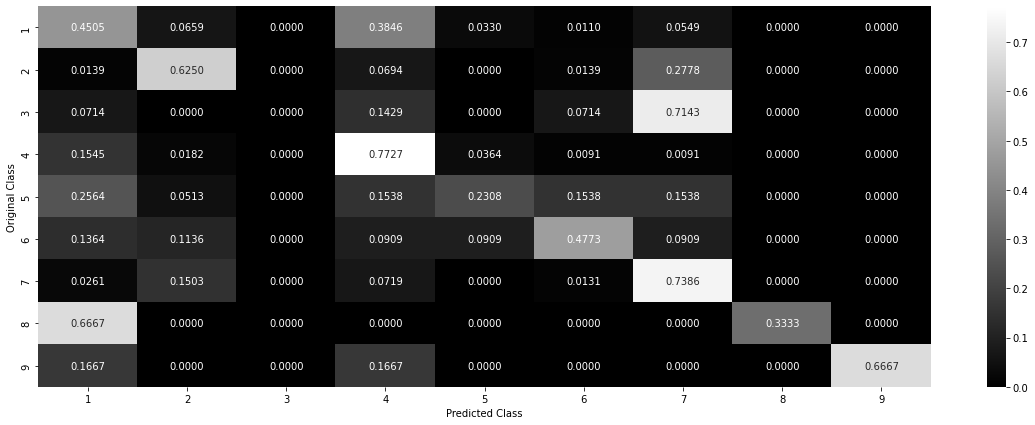

In [169]:
best_alpha_KNN=alpha[best_alpha]
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

In [170]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  20  nearest neighbours of the test points belongs to classes [7 7 7 7 7 7 7 7 5 7 7 7 7 7 7 7 7 2 7 5]
Fequency of nearest points : Counter({7: 17, 5: 2, 2: 1})


## Logistic Regression

#### With Class balancing

For value of alpha  1e-05 the log loss is  1.1876018279203795
For value of alpha  0.0001 the log loss is  1.046315857554241
For value of alpha  0.001 the log loss is  1.0365477650446189
For value of alpha  0.01 the log loss is  1.1554722289623203
For value of alpha  0.1 the log loss is  1.4286865806863975
For value of alpha  1 the log loss is  1.5337675884999071
For value of alpha  10 the log loss is  1.5467382949533468
For value of alpha  100 the log loss is  1.5479519526583783
For value of alpha  1000 the log loss is  1.5481957691747663


[]

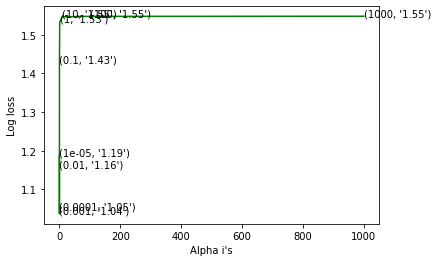

In [171]:
alpha=[10**x for x in range(-5,4)]
cv_log_error=[]
for i in alpha:
  clf=SGDClassifier(loss='log',penalty='l2',alpha=i,class_weight='balanced')
  clf.fit(train_x_onehotCoding,y_train)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_onehotCoding,y_train)
  sig_prob=sig_clf.predict_proba(cv_x_onehotCoding)
  cv_log_error.append(log_loss(cv_y,sig_prob,labels=clf.classes_,eps=1e-15))
  print("For value of alpha ",i,'the log loss is ',cv_log_error[-1])

fog,ax=plt.subplots()
ax.plot(alpha,cv_log_error,c='g')
for i,txt in enumerate(np.round(cv_log_error,2)):
  ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.xlabel("Alpha i's")
plt.ylabel('Log loss')
plt.plot()

In [172]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.44674096182655965
For values of best alpha =  0.0001 The cross validation log loss is: 1.0353409530346893
For values of best alpha =  0.0001 The test log loss is: 1.0888328824155804


Log loss : 1.0353409530346893
Number of mis-classified points : 0.34022556390977443
						  Confusion Matrix 



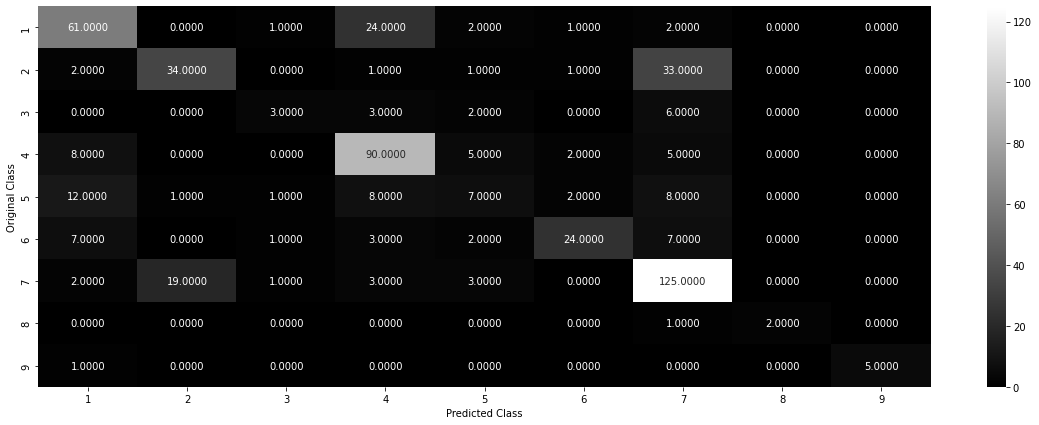

						  Precision Matrix  		



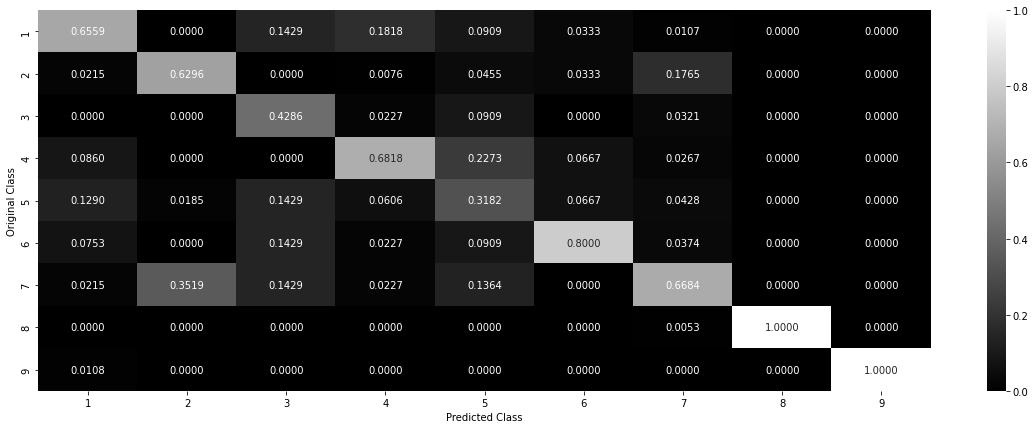

						  Recall Matrix  		


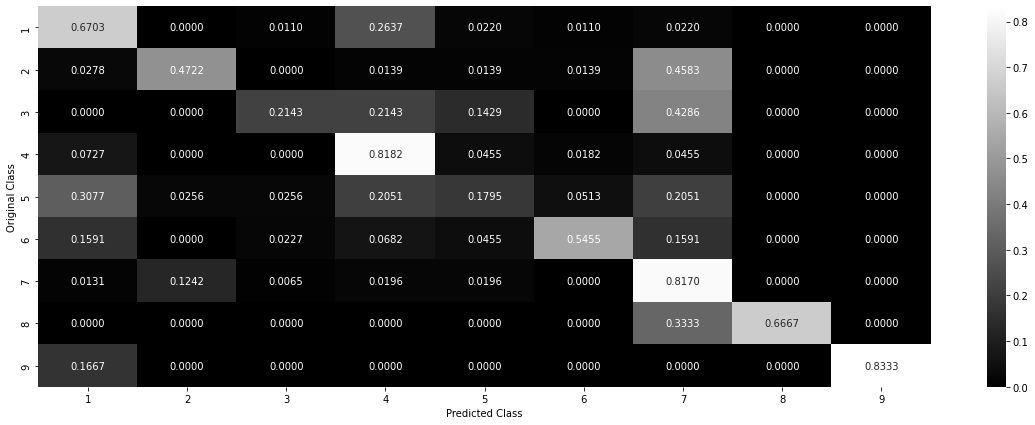

In [173]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [174]:
best_alpha_LR=alpha[best_alpha]

### Feature Importance

In [175]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [176]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 10
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1891 0.0396 0.0065 0.6668 0.0204 0.0058 0.0581 0.0065 0.0072]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


#### Without Class balancing

For alpha  1e-05  log loss is  1.1988552302130568
For alpha  0.0001  log loss is  1.0590033056841157
For alpha  0.001  log loss is  1.045949834043475
For alpha  0.01  log loss is  1.174983973941668
For alpha  0.1  log loss is  1.3560177382844025
For alpha  1  log loss is  1.480455188398386
For alpha  10  log loss is  1.5011157291805928
For alpha  100  log loss is  1.5035156332713617
For alpha  1000  log loss is  1.5041097400898606
For alpha  10000  log loss is  1.4975592925154064
For values of best alpha =  0.001 The train log loss is: 0.501253907856251
For values of best alpha =  0.001 The cross validation log loss is: 1.0452330597895547
For values of best alpha =  0.001 The test log loss is: 1.091423030493378


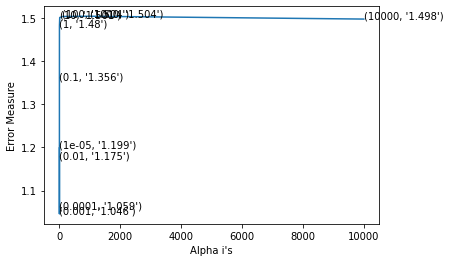

In [177]:
alpha=[10**x for x in range(-5,5)]
cv_log_error=[]
for i in alpha:
  clf=SGDClassifier(alpha=i,loss='log',penalty='l2')
  clf.fit(train_x_onehotCoding,train_y)
  sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
  sig_clf.fit(train_x_onehotCoding,train_y)
  predict_y=sig_clf.predict_proba(cv_x_onehotCoding)
  cv_log_error.append(log_loss(cv_y,predict_y,labels=clf.classes_,eps=1e-15))
  print('For alpha ',i,' log loss is ',cv_log_error[-1])

fig,ax=plt.subplots()
ax.plot(alpha,cv_log_error)
for i,txt in enumerate(np.round(cv_log_error,3)):
  ax.annotate((alpha[i],str(txt)),(alpha[i],cv_log_error[i]))
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.plot()
best_alpha=np.argmin(cv_log_error)
clf=SGDClassifier(alpha=alpha[best_alpha],loss='log',penalty='l2')
clf.fit(train_x_onehotCoding,train_y)
sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotCoding,train_y)
predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.043788567879101
Number of mis-classified points : 0.34774436090225563
						  Confusion Matrix 



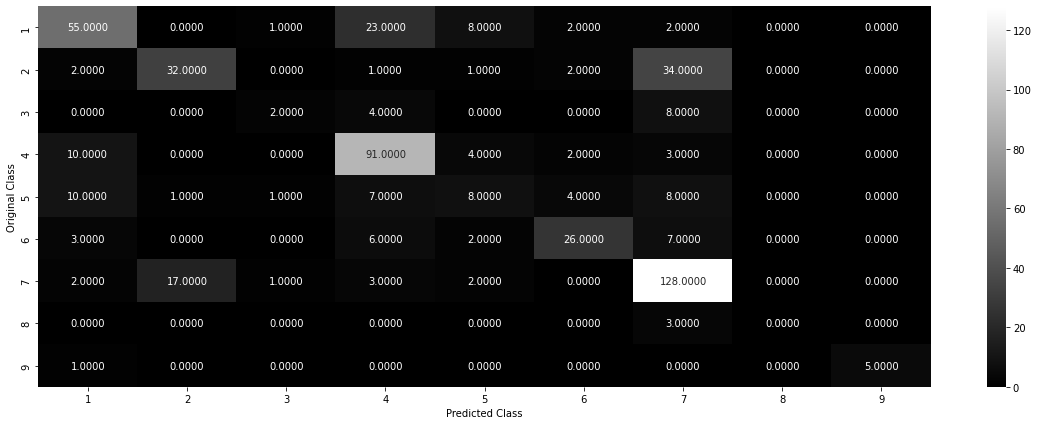

						  Precision Matrix  		



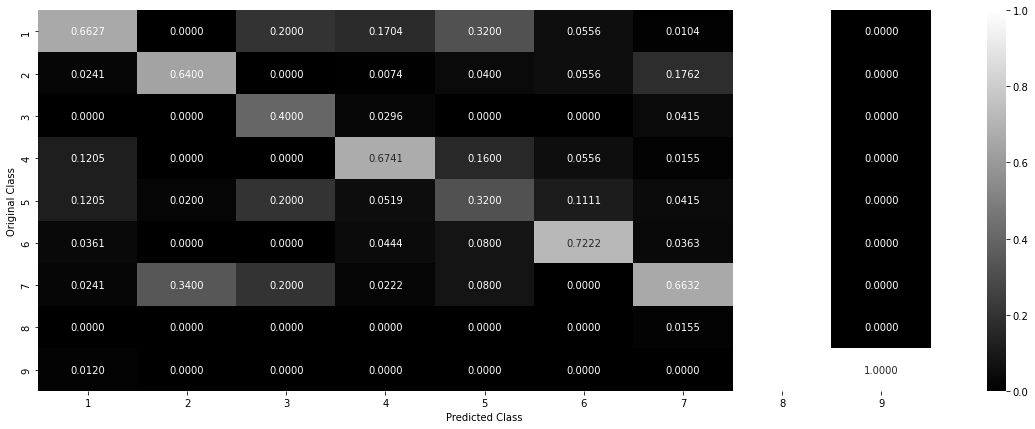

						  Recall Matrix  		


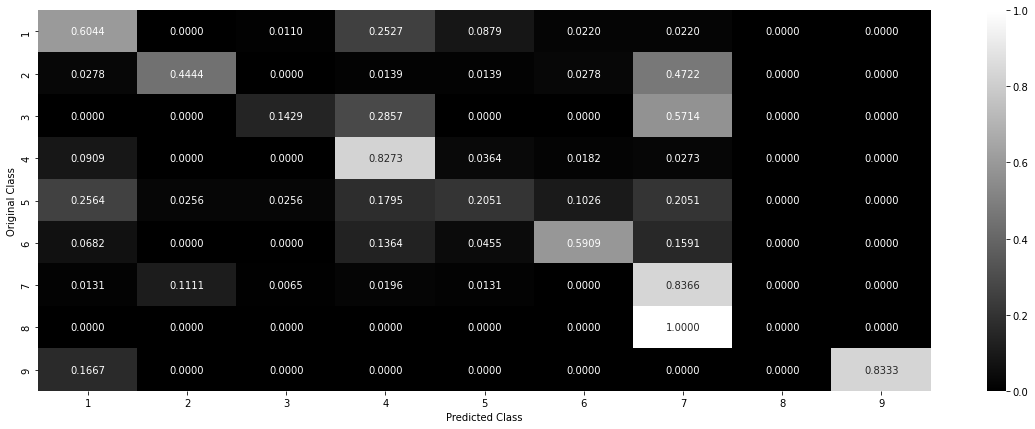

In [178]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [179]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0354 0.0746 0.0312 0.0346 0.0528 0.0226 0.7372 0.006  0.0056]]
Actual Class : 7
--------------------------------------------------
163 Text feature [rger] present in test data point [True]
245 Text feature [rc] present in test data point [True]
290 Text feature [33] present in test data point [True]
321 Text feature [eph] present in test data point [True]
427 Text feature [cr] present in test data point [True]
480 Text feature [lkg1269] present in test data point [True]
Out of the top  500  features  6 are present in query point


## Support Vector Machines

For alpha  1e-05  log loss is  1.4975592925154064
For alpha  0.0001  log loss is  1.4975592925154064
For alpha  0.001  log loss is  1.4975592925154064
For alpha  0.01  log loss is  1.4975592925154064
For alpha  0.1  log loss is  1.4975592925154064
For alpha  1  log loss is  1.4975592925154064
For alpha  10  log loss is  1.4975592925154064
For alpha  100  log loss is  1.4975592925154064


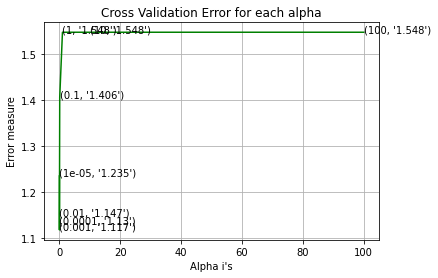

For values of best alpha =  0.001 The train log loss is: 0.4925282449192807
For values of best alpha =  0.001 The cross validation log loss is: 1.1169357907198911
For values of best alpha =  0.001 The test log loss is: 1.1616470924600277


In [180]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
  
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print('For alpha ',i,' log loss is ',cv_log_error[-1])

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)

clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1169357907198911
Number of mis-classified points : 0.34022556390977443
						  Confusion Matrix 



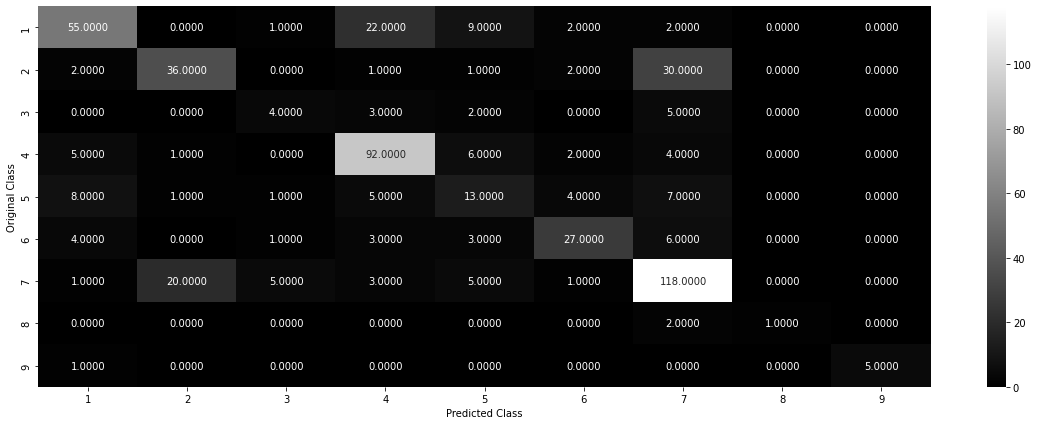

						  Precision Matrix  		



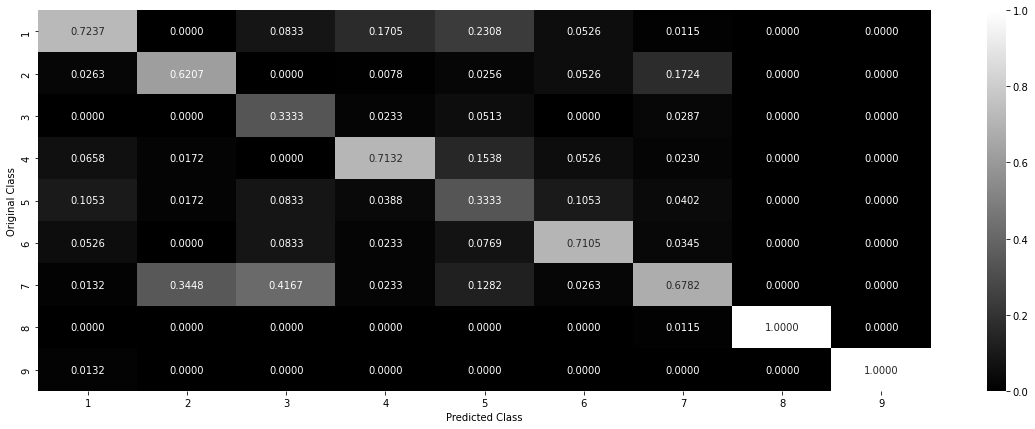

						  Recall Matrix  		


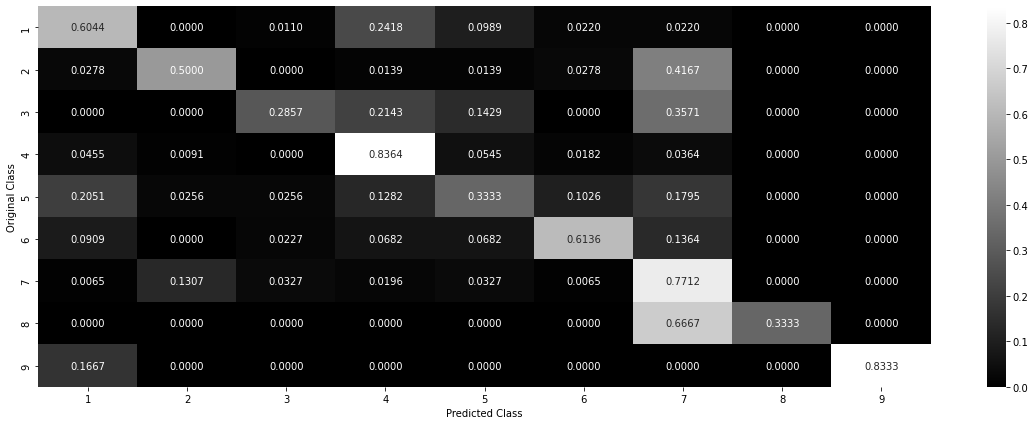

In [181]:
best_alpha_SVM=alpha[best_alpha]
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

#### Feature Importance

In [182]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0769 0.0573 0.0154 0.0619 0.0375 0.0304 0.7095 0.0053 0.0057]]
Actual Class : 7
--------------------------------------------------
313 Text feature [rger] present in test data point [True]
353 Text feature [equ] present in test data point [True]
Out of the top  500  features  2 are present in query point


## Random Forest Classifier

for n_estimators = 100 and max depth =  5 Log Loss : 1.3540616032969193
for n_estimators = 100 and max depth =  10 Log Loss : 1.2677367191484625
for n_estimators = 100 and max depth =  15 Log Loss : 1.229747031650583
for n_estimators = 200 and max depth =  5 Log Loss : 1.3493656972952737
for n_estimators = 200 and max depth =  10 Log Loss : 1.2470239341394806
for n_estimators = 200 and max depth =  15 Log Loss : 1.2206854877765678
for n_estimators = 300 and max depth =  5 Log Loss : 1.3490110415385146
for n_estimators = 300 and max depth =  10 Log Loss : 1.2498766781580093
for n_estimators = 300 and max depth =  15 Log Loss : 1.2154029731419025
for n_estimators = 400 and max depth =  5 Log Loss : 1.3460863861762797
for n_estimators = 400 and max depth =  10 Log Loss : 1.250633379781634
for n_estimators = 400 and max depth =  15 Log Loss : 1.2130662146491857
for n_estimators = 500 and max depth =  5 Log Loss : 1.3425322427604531
for n_estimators = 500 and max depth =  10 Log Loss : 1.24

ValueError: ignored

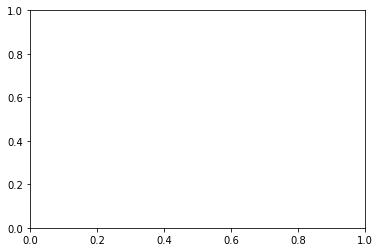

In [183]:
alpha=[100*x for x in range(1,10)]
max_depth=[5*k for k in range(1,4)]

cv_log_error=[]
for i in alpha:
    for j in max_depth:

        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("for n_estimators =", i,"and max depth = ", j,"Log Loss :",log_loss(cv_y, sig_clf_probs)) 


     




In [185]:

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/3)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The cross validation log loss is:",log_loss(Y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/3)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  100 The train log loss is: 0.439255618526531
For values of best alpha =  100 The cross validation log loss is: 1.0687978467447485
For values of best alpha =  100 The test log loss is: 1.162464401769171


Log loss : 1.3493656972952737
Number of mis-classified points : 0.45864661654135336
						  Confusion Matrix 



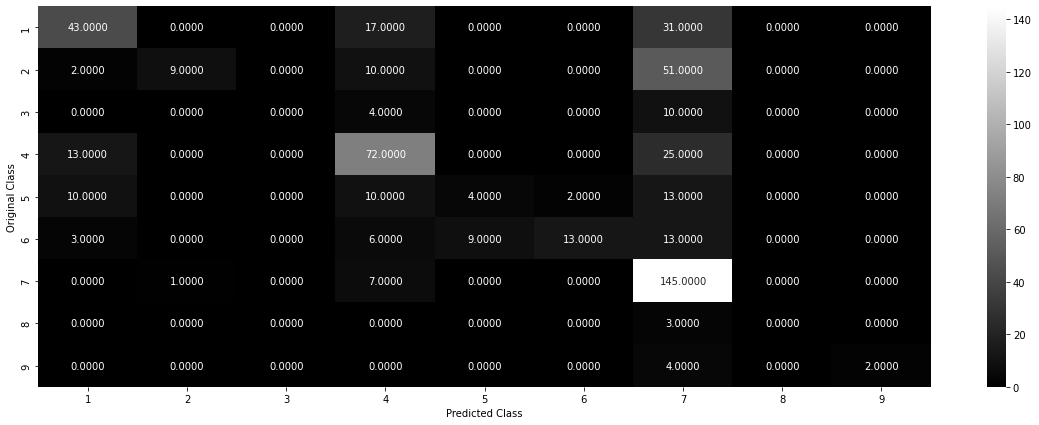

						  Precision Matrix  		



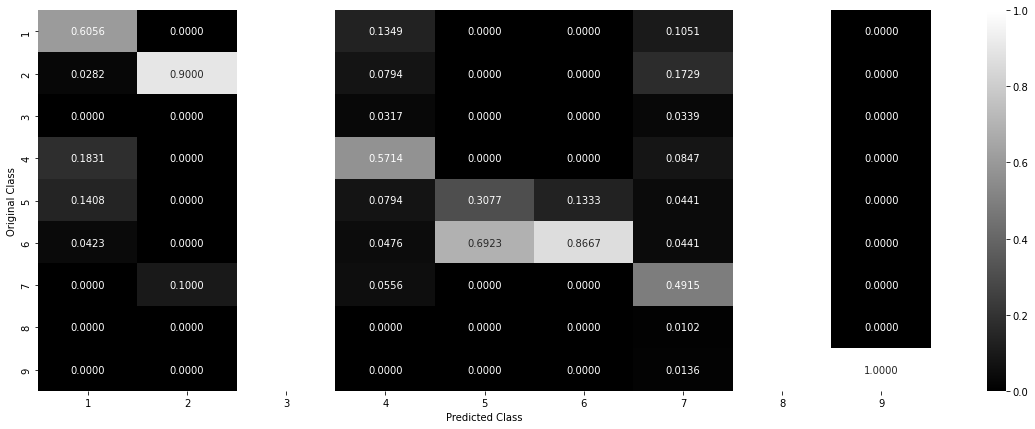

						  Recall Matrix  		


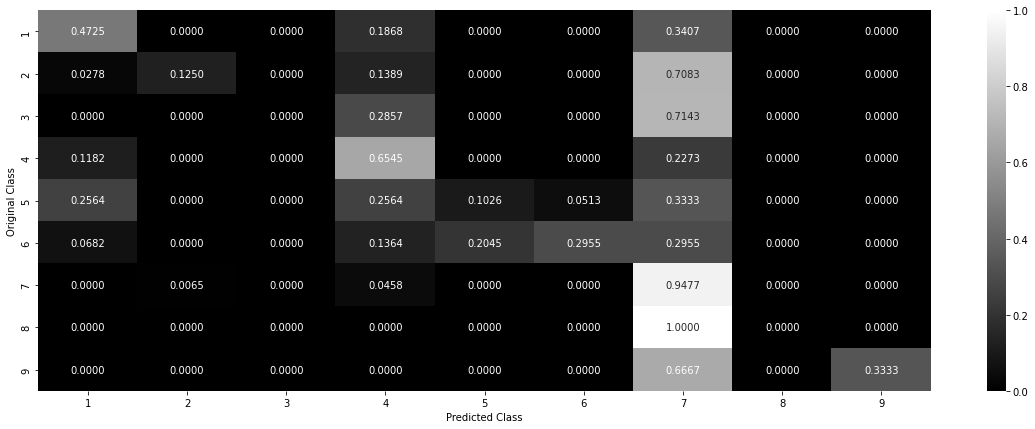

In [186]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

In [187]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['Text'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0666 0.2961 0.023  0.0762 0.0503 0.0447 0.433  0.0056 0.0044]]
Actual Class : 2
--------------------------------------------------
38 Text feature [l755p] present in test data point [True]
Out of the top  100  features  1 are present in query point


## Stack the models


In [201]:
clf1 = SGDClassifier(alpha=best_alpha_LR, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=best_alpha_SVM, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=best_alpha_NB)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

clf4=KNeighborsClassifier(n_neighbors=best_alpha_KNN)
clf4.fit(train_x_onehotCoding, train_y)
sig_clf4 = CalibratedClassifierCV(clf4, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("K Nearest : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf4.fit(train_x_onehotCoding, train_y)
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
estimators=[('svm',sig_clf2),('rfc',sig_clf),('gnb',sig_clf3),('knn',sig_clf4),('lrr',sig_clf1)]
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier( estimators=estimators, final_estimator=lr)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.04
Support vector machines : Log Loss: 1.12
Naive Bayes : Log Loss: 1.23
K Nearest : Log Loss: 1.12
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.815
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.696
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.285
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.024
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.984
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.050


Log loss (train) on the stacking classifier : 0.39204135985089955
Log loss (CV) on the stacking classifier : 0.9843354945874617
Log loss (test) on the stacking classifier : 1.0153563404231625
Number of missclassified point : 0.35639097744360904
						  Confusion Matrix 



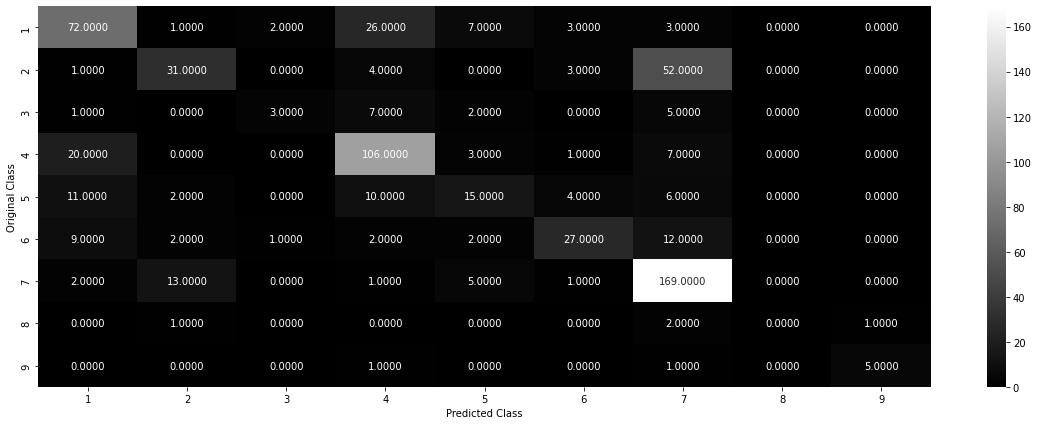

						  Precision Matrix  		



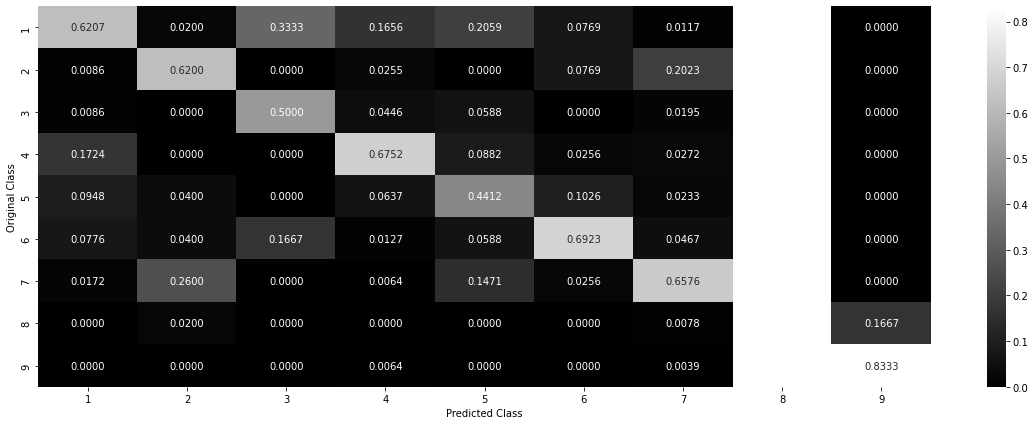

						  Recall Matrix  		


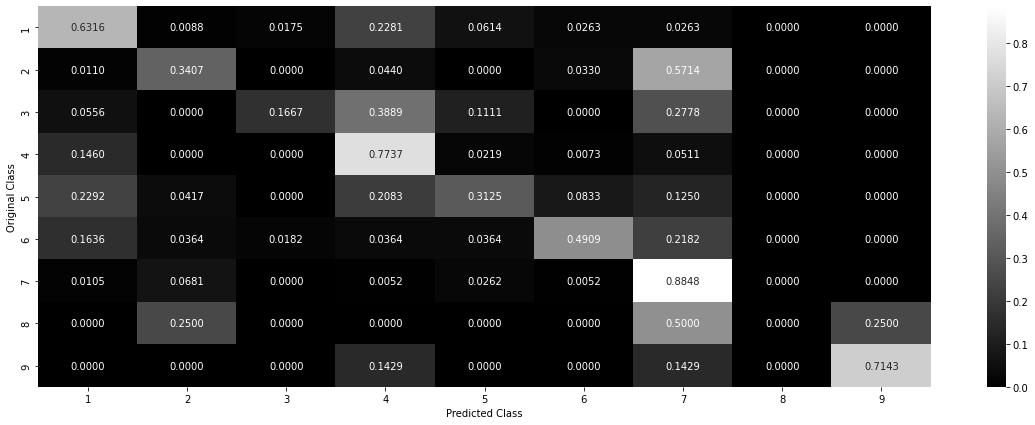

In [203]:
lr = LogisticRegression(C=1)
sclf = StackingClassifier( estimators=estimators, final_estimator=lr)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))